# Implementing back propagation from the scratch
- Pytorch loss.backward() workings and comparing them to manual gradients created by this implementation

### Data

In [1]:
import torch
import torch.nn.functional as Func
import matplotlib.pyplot as plt  # for making figures
import random
import math

%matplotlib inline

In [2]:
# Black code formatter (Optional)
%load_ext lab_black

In [3]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


#### Creating the data set for the model

In [6]:
# build the dataset
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    """
    This builds the dataset and split it into the appropriate sets

    Args:
        - Words: A file containing all the names

    Returns:
        - X: A tensor containing the previous sequence of characters
        - Y: A tensor containing the next character
    """
    X, Y = [], []
    for w in words:
        # print(w)

        context = [0] * block_size

        for ch in w + ".":
            ix = stoi[ch]
            X.append(
                context
            )  # append a list of block size 3 for the number of chars in a word
            Y.append(ix)  # append the character number
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [7]:
# Sampling from the dataset
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### Boilerplate

In [8]:
def cmp(s, dt, t):
    """
    An Utility function used for comparing manual gradients to PyTorch gradients

    Args:
        s:
        dt:
        t:

    Returns:
        A boolean value if they are exact or approximately close or not and the maximum 
        difference between them
    """
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(
        f"{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}"
    )

In [53]:
# Initialization
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

gen = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=gen)

# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=gen) * (
    (5 / 3) / math.sqrt(n_embd * block_size)
)
b1 = torch.randn(n_hidden, generator=gen) * 0.01

# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=gen) * 0.1
b2 = (
    torch.randn(vocab_size, generator=gen) * 0.1
)  # initialize b2 as a smaller value to remove the bias

# batch normalization parameters
bnGain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnBias = torch.randn((1, n_hidden)) * 0.1

# Most of the parameters are initialized in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.
parameters = [C, W1, b1, W2, b2, bnBias, bnGain]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

12297


In [54]:
# Constructing the Minibatch
batch_size = 32
n = batch_size
ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=gen)
X_batch, Y_batch = X_train[ix], Y_train[ix]  # batch X,Y

In [55]:
# Forward pass
emb = C[X_batch]  # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors

## Linear layer
hprebn = embcat @ W1 + b1  # hidden layer pre-activation

# Batch Normalization layer
# -------------------------------------------------------------
bnMeani = 1 / n * hprebn.sum(0, keepdim=True)
bnDiff = hprebn - bnMeani
bnDiff2 = bnDiff**2
bnVar = (
    1 / (n - 1) * (bnDiff2).sum(0, keepdim=True)
)  # note: Bessel's correction (dividing by n-1, not n)
bnVar_inv = (bnVar + 1e-5) ** -0.5
bnraw = bnDiff * bnVar_inv
hpreact = bnGain * bnraw + bnBias
# -------------------------------------------------------------

## Non-linearity
h = torch.tanh(hpreact)  # hidden layer

# Linear layer 2
logits = h @ W2 + b2  # output layer

# Cross entropy Loss function
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes  # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = (
    counts_sum**-1
)  # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Y_batch].mean()


# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [
    logprobs,
    probs,
    counts,
    counts_sum,
    counts_sum_inv,  # afaik there is no cleaner way
    norm_logits,
    logit_maxes,
    logits,
    h,
    hpreact,
    bnraw,
    bnVar_inv,
    bnVar,
    bnDiff2,
    bnDiff,
    hprebn,
    bnMeani,
    embcat,
    emb,
]:
    t.retain_grad()
loss.backward()
loss

tensor(3.7524, grad_fn=<NegBackward0>)

### Exercise 1:  Backprop through the whole thing manually, 
backpropagating through exactly all of the variables as they are defined in the forward pass above, one by one

In [56]:
# dlogprobs: calculation of the gradient/derivative of the loss wrt all the elements of the logprobs tensor
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Y_batch] = -1.0 / n
cmp("logprobs", dlogprobs, logprobs)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


In [57]:
# the local derivate of log * the derivate loss wrt to its output (dlogprobs)
# d/d(x) of log(x) = 1/x
dprobs = (1.0 / probs) * dlogprobs
cmp("probs", dprobs, probs)

probs           | exact: True  | approximate: True  | maxdiff: 0.0


In [58]:
# probs = counts * counts_sum_inv
# the local derivative of counts (dp/dcsi) * the derivate loss wrt to probs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
cmp("Counts_sum_inv", dcounts_sum_inv, counts_sum_inv)

Counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0


In [59]:
# the local derivative of counts_sum_inv (dp/dc) * the derivate loss wrt to probs
dcounts = counts_sum_inv * dprobs
# cmp("Counts", dcounts, counts)

In [60]:
# d/dx(x**-1) = -1/x**2
dcounts_sum = (-(counts_sum**-2)) * dcounts_sum_inv
cmp("Counts_sum", dcounts_sum, counts_sum)

Counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0


In [61]:
# second branch of dcounts
dcounts += torch.ones_like(counts) * dcounts_sum
cmp("Counts", dcounts, counts)

Counts          | exact: True  | approximate: True  | maxdiff: 0.0


In [62]:
# the local derivate of exp * the derivate loss wrt to its output (counts)
# d(a^x)/dx = a^x * ln a
dnorm_logits = counts * dcounts
cmp("norm_logits", dnorm_logits, norm_logits)

norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0


In [63]:
# norm_logits = logits - logit_maxes
dlogits = dnorm_logits.clone()
dlogits_maxes = (-dnorm_logits).sum(1, keepdim=True)
cmp("logit_maxes", dlogits_maxes, logit_maxes)

logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0


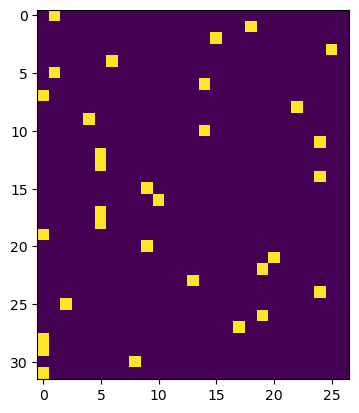

In [64]:
# an array of where the maximum values came from for logits
plt.imshow(Func.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))

In [65]:
dlogits += (
    Func.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogits_maxes
)
cmp("logits", dlogits, logits)

logits          | exact: True  | approximate: True  | maxdiff: 0.0


In [66]:
# logits = h @ W2 + b2
# dL/dh = dL/dlogits @ w2-transpose
dh = dlogits @ W2.T
cmp("h", dh, h)

h               | exact: True  | approximate: True  | maxdiff: 0.0


In [67]:
# dL/dw2 = h-transpose @ dL/dlogits
dW2 = h.T @ dlogits
cmp("W2", dW2, W2)

W2              | exact: True  | approximate: True  | maxdiff: 0.0


In [68]:
# dL/db2 = dL/dLogits.sum(0)
db2 = dlogits.sum(0)
cmp("b2", db2, b2)

b2              | exact: True  | approximate: True  | maxdiff: 0.0


In [69]:
# h = torch.tanh(hpreact)
# derivative of tanh = 1 - a**2, where a is the output of the tanh
dhpreact = (1.0 - h**2) * dh
cmp("hpreact", dhpreact, hpreact)

hpreact         | exact: True  | approximate: True  | maxdiff: 0.0


In [70]:
# hpreact = bnGain * bnraw + bnBias
dbnGain = (bnraw * dhpreact).sum(0, keepdim=True)

cmp("bngain", dbnGain, bnGain)

bngain          | exact: True  | approximate: True  | maxdiff: 0.0


In [71]:
dbnraw = bnGain * dhpreact
cmp("bnraw", dbnraw, bnraw)

bnraw           | exact: True  | approximate: True  | maxdiff: 0.0


In [72]:
dbnBias = (dhpreact).sum(0, keepdim=True)
cmp("bnbias", dbnBias, bnBias)

bnbias          | exact: True  | approximate: True  | maxdiff: 0.0


In [73]:
# bnraw = bnDiff * bnVar_inv
dbnDiff = bnVar_inv * dbnraw
cmp("bnDiff", dbnDiff, bnDiff)

bnDiff          | exact: False | approximate: False | maxdiff: 0.0012436023680493236


In [74]:
# bnraw = bnDiff * bnVar_inv
dbnVar_inv = (bnDiff * dbnraw).sum(0, keepdim=True)
cmp("bnvar_inv", dbnVar_inv, bnVar_inv)

bnvar_inv       | exact: True  | approximate: True  | maxdiff: 0.0


In [75]:
# d(x^n)/dx = nx^(n-1)
# bnVar_inv = (bnVar + 1e-5) ** -0.5
dbnVar = (-0.5 * ((bnVar + 1e-5) ** -1.5)) * dbnVar_inv
cmp("bnvar", dbnVar, bnVar)

bnvar           | exact: True  | approximate: True  | maxdiff: 0.0


In [76]:
# bnVar = (1 / (n - 1) * (bnDiff2).sum(0, keepdim=True))
dbnDiff2 = (1.0 / (n - 1)) * torch.ones_like(bnDiff2) * dbnVar
cmp("bnDiff2", dbnDiff2, bnDiff2)

bnDiff2         | exact: True  | approximate: True  | maxdiff: 0.0


In [77]:
bnDiff2.shape, bnDiff.shape

(torch.Size([32, 200]), torch.Size([32, 200]))

In [78]:
# bnDiff2 = bnDiff**2
dbnDiff += (2 * bnDiff) * dbnDiff2
cmp("bnDiff", dbnDiff, bnDiff)

bnDiff          | exact: True  | approximate: True  | maxdiff: 0.0


In [79]:
# bnDiff = hprebn - bnMeani
dbnMeani = (-dbnDiff).sum(0)
cmp("bnmeani", dbnMeani, bnMeani)

bnmeani         | exact: True  | approximate: True  | maxdiff: 0.0


In [80]:
dhprebn = dbnDiff.clone()
cmp("hprebn", dhprebn, hprebn)

hprebn          | exact: False | approximate: False | maxdiff: 0.0015779449604451656


In [81]:
# bnMeani = 1 / n * hprebn.sum(0, keepdim=True)
dhprebn += ((1 / n) * torch.ones_like(hprebn)) * dbnMeani
cmp("hprebn", dhprebn, hprebn)

hprebn          | exact: True  | approximate: True  | maxdiff: 0.0


In [83]:
# hprebn = embcat @ W1 + b1
dembcat = dhprebn @ W1.T
cmp("embcat", dembcat, embcat)

embcat          | exact: True  | approximate: True  | maxdiff: 0.0


In [84]:
dW1 = embcat.T @ dhprebn
cmp("W1", dW1, W1)

W1              | exact: True  | approximate: True  | maxdiff: 0.0


In [85]:
db1 = dhprebn.sum(0)
cmp("b1", db1, b1)

b1              | exact: True  | approximate: True  | maxdiff: 0.0


In [86]:
# embcat = emb.view(emb.shape[0], -1)
demb = dembcat.view(emb.shape)
cmp("emb", demb, emb)

emb             | exact: True  | approximate: True  | maxdiff: 0.0


In [87]:
# emb = C[X_batch]
dC = torch.zeros_like(C)
for k in range(X_batch.shape[0]):
    for j in range(X_batch.shape[1]):
        ix = X_batch[k, j]
        dC[ix] += demb[k, j]
cmp("C", dC, C)

C               | exact: True  | approximate: True  | maxdiff: 0.0


#### **Combined Results**

In [89]:
cmp("logprobs", dlogprobs, logprobs)
cmp("probs", dprobs, probs)
cmp("counts_sum_inv", dcounts_sum_inv, counts_sum_inv)
cmp("counts_sum", dcounts_sum, counts_sum)
cmp("counts", dcounts, counts)
cmp("norm_logits", dnorm_logits, norm_logits)
cmp("logit_maxes", dlogits_maxes, logit_maxes)
cmp("logits", dlogits, logits)
cmp("h", dh, h)
cmp("W2", dW2, W2)
cmp("b2", db2, b2)
cmp("hpreact", dhpreact, hpreact)
cmp("bnGain", dbnGain, bnGain)
cmp("bnbias", dbnBias, bnBias)
cmp("bnraw", dbnraw, bnraw)
cmp("bnVar_inv", dbnVar_inv, bnVar_inv)
cmp("bnVar", dbnVar, bnVar)
cmp("bnDiff2", dbnDiff2, bnDiff2)
cmp("bnDiff", dbnDiff, bnDiff)
cmp("bnmeani", dbnMeani, bnMeani)
cmp("hprebn", dhprebn, hprebn)
cmp("embcat", dembcat, embcat)
cmp("W1", dW1, W1)
cmp("b1", db1, b1)
cmp("emb", demb, emb)
cmp("C", dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bnGain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: